In [ ]:
import pandas as pd

# Load the dataset
airbnb_data = pd.read_csv('/content/airbnb_Chicago (1).csv')

# Display the first few rows to understand its structure
print(airbnb_data.head())


   Airbnb Host ID  Airbnb Property ID   City_x  superhost_period_all  \
0          2153.0              1947.0  Chicago                  13.0   
1          2153.0              1947.0  Chicago                  15.0   
2          2153.0              1947.0  Chicago                  18.0   
3          2153.0              1947.0  Chicago                  19.0   
4          2153.0              1947.0  Chicago                  20.0   

   scrapes_in_period Scraped Date  superhost_observed_in_period  \
0               15.0   2018-08-05                          15.0   
1               14.0   2019-02-12                          14.0   
2               28.0   2019-11-05                          28.0   
3               41.0   2020-02-02                          41.0   
4               33.0   2020-05-01                          33.0   

   host_is_superhost_in_period  superhost_ratio  prev_superhost_period_all  \
0                          0.0              0.0                       12.0   
1       

In [ ]:
# Check for missing values
missing_values = airbnb_data.isnull().sum()
print(missing_values)

# Handle missing values (options: dropna, fillna, etc.)
# Example: Filling missing values with the median
airbnb_data.fillna(airbnb_data.median(), inplace=True)

Airbnb Host ID                0
Airbnb Property ID            0
City_x                        0
superhost_period_all          0
scrapes_in_period             0
                          ...  
revenue_period_tract          0
tract_booking_share           0
tract_revenue_share           0
time_to_date_mean         38108
prev_time_to_date_mean    44631
Length: 111, dtype: int64


<ipython-input-2-b63e3689512b>:7: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  airbnb_data.fillna(airbnb_data.median(), inplace=True)


In [ ]:
import numpy as np
# Select only numeric columns for IQR calculation
numeric_data = airbnb_data.select_dtypes(include=[np.number])

# Calculate IQR for each numeric column
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the dataset
# Use 'any(axis=1)' to remove a row if any column has an outlier
airbnb_data = airbnb_data[~((numeric_data < lower_bound) | (numeric_data > upper_bound)).any(axis=1)]


In [ ]:
print(airbnb_data.shape)

(4978, 111)


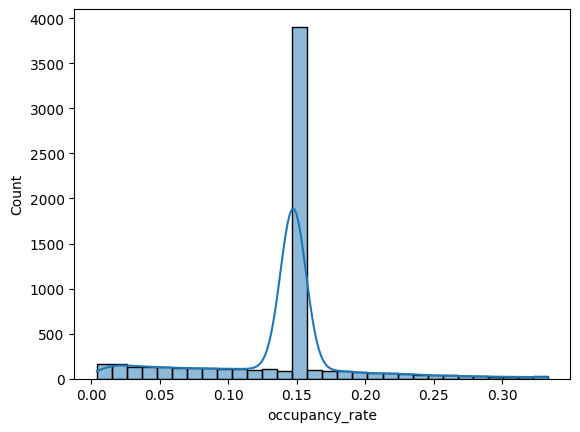

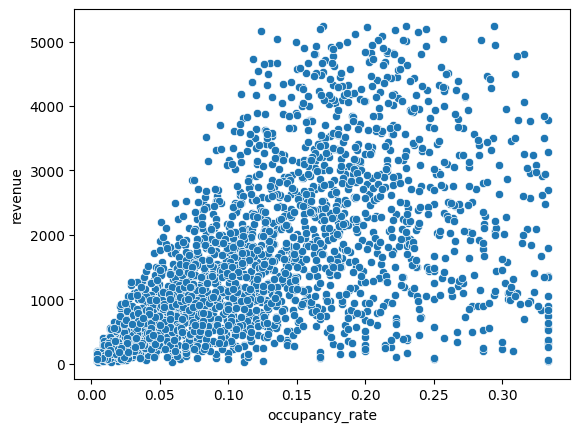

In [ ]:
# Visualizations for EDA
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of key features
sns.histplot(airbnb_data['occupancy_rate'], bins=30, kde=True)
plt.show()

# Relationship between occupancy rate and revenue
sns.scatterplot(x='occupancy_rate', y='revenue', data=airbnb_data)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare the features and target variable
X = airbnb_data[['occupancy_rate', 'booked_days', 'Nightly Rate']]  # replace with actual feature column names
y = airbnb_data['revenue']  # replace with your target column if different

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

# Impute missing values using the median for each column
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_train)

# Now X_imputed can be used with SelectKBest
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_imputed, y_train)

# Get the columns to keep and convert to a list
cols = selector.get_support(indices=True)
features_df_new = X_train.iloc[:, cols]

In [ ]:
# For example, if you have a 'date_listed' feature, you could derive a 'listing_age' feature
# Assume 'date_listed' is in the format 'YYYY-MM-DD'
import pandas as pd
import numpy as np

airbnb_data['listing_age'] = (pd.to_datetime('now') - pd.to_datetime(airbnb_data['Created Date'])).dt.days

# Log-transform of the target variable if it's highly skewed
airbnb_data['log_revenue'] = np.log1p(airbnb_data['revenue'])

<ipython-input-7-4e7f962c6411>:6: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  airbnb_data['listing_age'] = (pd.to_datetime('now') - pd.to_datetime(airbnb_data['Created Date'])).dt.days


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# Select top k features
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)

# Get the columns to keep and convert to a list
cols = selector.get_support(indices=True)
features_df_new = X_train.iloc[:,cols]


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-validation
scores = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=5)
print(f"Average cross-validation R^2 score: {scores.mean()}")

Average cross-validation R^2 score: 0.8649779938240325


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best model
best_rf_model = grid_search.best_estimator_

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Predict on the test set with the best model
y_pred = best_rf_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 86762.97207186898
R-squared (R2): 0.8639048883606072


In [ ]:
import numpy as np

# Define a range for occupancy rates (e.g., from 0% to 100% in 1% increments)
min_occupancy_rate = airbnb_data['occupancy_rate'].min()
max_occupancy_rate = airbnb_data['occupancy_rate'].max()

occupancy_range = np.linspace(min_occupancy_rate, max_occupancy_rate, num=50)


In [ ]:
import pandas as pd

# Create a DataFrame with occupancy rates
prediction_df = pd.DataFrame(occupancy_range, columns=['occupancy_rate'])

# Add average values for all other features used in the model
for feature in ['occupancy_rate', 'booked_days', 'Nightly Rate']:  # Replace with actual feature names
    prediction_df[feature] = airbnb_data[feature].mean()  # Replace with appropriate average values


In [ ]:
prediction_df['predicted_revenue'] = best_rf_model.predict(prediction_df)


In [ ]:
# Find the scenario with the highest predicted revenue
optimal_scenario = prediction_df.loc[prediction_df['predicted_revenue'].idxmax()]
optimal_occupancy_rate = optimal_scenario['occupancy_rate']
max_revenue = optimal_scenario['predicted_revenue']

print(f"Optimal occupancy rate: {optimal_occupancy_rate*100}%")
print(f"Predicted maximum revenue at this occupancy rate: {max_revenue}")


Optimal occupancy rate: 13.648634756797337%
Predicted maximum revenue at this occupancy rate: 1721.1563063554609
